In [1]:
from collections import OrderedDict
import csv
from gensim import corpora, models
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import numpy as np
import pandas as pd
from pprint import pprint
import pymc as pm
from sklearn.feature_extraction.text import TfidfVectorizer

### Function Definitions

In [2]:
def data_to_path(filepath, qty):
    #INPUT: filepath, path to data
    #INPUT: shortener, quantity to cut data (to run faster)

    #import data
    pre_df = pd.read_csv(filepath, header=1)

    #Create a numpy array of user journeys
    paths = np.array([ 'Path'])
    for i in range(2, qty):
        #select random row without replacement
        #range starts at row 3 to not include headers
        row_ind = np.random.choice(range(3, len(pre_df)), replace = False)
        #extract path from row
        path = list(str(pre_df.iloc[row_ind, :]).split())[1]
        #add path to paths numpy array
        paths = np.vstack((paths, path))

    for journey in range(len(paths)):
        paths[journey] = paths[journey][0].replace('->', ' ')
    #transpose data so that each journey is no longer a new column
    #after this transpose, each journey is a row
    paths = np.transpose(paths)
    return paths

In [3]:
def paths_to_docs(path):
    #INPUT: path, output of data_to_paths() function
    #OUTPUT: words, a list of documents (list of lists of words)
    words = []
    for val in path:
        for string in val:
            word_list = string.split()
            #treat journey.entry as stopword.
            words.append(string.split()[1:-1])
    return words

In [4]:
def words_to_corpus(words):
    #INPUT: list of lists of words
    #OUTPUT: Corpus of words matched with frequency and dictionary
    dictionary = corpora.Dictionary(words)
    corpus = [dictionary.doc2bow(text) for text in words]
    return corpus, dictionary

In [5]:
def gen_lda_model(corpus, dictionary, topic_qty = 10, word_qty=4):
    #INPUT: corpus and dictionary.
    #INPUT: topic_qty: how many topics to cluster
    #INPUT: word_qty: how many words
    #OUPUT: lda model in gensim print format

    ldamodel = models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)
    return ldamodel.print_topics(num_topics=topic_qty, num_words = word_qty)

In [6]:
def split_nums_names(topics_list):
    #INPUT: LDA model in gensim printed format
    #OUTPUT: num_vals, list of percents of topic explained by each term
    #OUTPUT: name_vals, list of terms
    num_vals = []
    name_vals = []
    for idx, topic in enumerate(topics_list):
        # * sign splits number and term, hence we split on it
        topic_split = topic[1].split('*')
        # There is always 1 num val before the names
        #we are simultaneously instantiating this num_vals list
        num_vals.append([topic_split[0]])
        #instantiate name_vals list
        name_vals.append([])
        #for loop to add values to num_vals and name_vals lists
        for word_num in topic_split[1:]:
            word_num =  word_num.split('+')
            #we test if word_num > 1 to make sure we have a pair of word and number (we do not always)
            if len(word_num) > 1:
                num_vals[idx].append(word_num[1])
            name_vals[idx].append(word_num[0])
    return num_vals, name_vals

In [7]:
def pandas_visualization(num_vals, name_vals, word_qty= 4, topic_qty= 10):
    #INPUT: ouput of split_num_names
    #INPUT: word_qty: quantity of words (columns) to show in dataframe
    #INPUT: topic_qty: number of topics (rows) to show in dataframe
    #OUPUT: Dataframe of results (for readability)
    n_themes = []
    for i in range(topic_qty):
        #current series is always the current row
        current_series = []
        names = [name_vals[i][0] for i in range(word_qty)]
        nums = [num_vals[i][0] for i in range(word_qty)]
        #alternatingly append name and value
        for i in range(word_qty):
            current_series.append(names[i])
            current_series.append(nums[i])
        n_themes.append(current_series)

    return pd.DataFrame(n_themes)

In [8]:
def graph_term_import(df_row, theme_num):
    #INPUT: df_row, a row from the output of pandas_visualization
    #INPUT: theme_num, the theme number
    #OUPUT: Horizontal Bar Chart of term import in theme
    #output is limited to 3 top terms.
    x = [df_row[i*2] for i in range(3)]
    y = [df_row[i*2+1] for i in range(3)]
    x_pos = np.arange(3)
    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot(111)
    ax.barh(x_pos, y, align='center', alpha=0.4)
    ax.set_yticks(x_pos)
    ax.set_yticklabels(x)
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Terms')
    ax.set_title('Theme {}'.format(theme_num))
    plt.show()

## Run Functions

In [9]:
filepath = '../../data/Top_Traversals_demo-1daybehavior_20140401.csv'
path = data_to_path(filepath, 100)

/Users/Trent/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [12]:
words = paths_to_docs(path)
print words

[[], ['web.entry', 'webevent.login'], ['web.entry', 'webevent.login'], ['web.entry', 'webevent.login'], ['agent.entry'], ['web.entry', 'webevent.login'], ['declined', 'chordiant'], ['web.entry', 'webevent.login'], [], ['web.entry', 'webevent.login'], ['web.entry'], ['web.entry', 'webevent.login'], ['web.entry', 'webevent.login'], ['web.entry'], ['web.entry', 'webevent.login'], ['web.entry', 'webevent.login'], ['agent.entry'], ['ivr.entry'], ['mobile.entry'], ['web.entry'], ['web.entry', 'webevent.login'], ['web.entry', 'webevent.login'], ['web.entry', 'webevent.login'], ['agent.entry'], ['mobile.entry'], ['agent.entry'], ['mobile.entry'], ['web.entry', 'webevent.login'], ['web.entry', 'webevent.login'], ['web.entry', 'webevent.login'], ['mobile.entry'], ['reward', 'web.entry'], ['mobile.entry'], ['web.entry', 'webevent.login'], ['ivr.entry'], ['web.entry', 'webevent.login'], ['agent.entry'], ['web.entry', 'webevent.login'], ['reward', 'mobile.entry'], ['mobile.entry'], ['web.entry', 'w

In [13]:
corpus, dictionary = words_to_corpus(words)
print corpus, '\n\n\n', dictionary

[[], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(2, 1)], [(0, 1), (1, 1)], [(3, 1), (4, 1)], [(0, 1), (1, 1)], [], [(0, 1), (1, 1)], [(0, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(0, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(2, 1)], [(5, 1)], [(6, 1)], [(0, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(2, 1)], [(6, 1)], [(2, 1)], [(6, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(6, 1)], [(0, 1), (7, 1)], [(6, 1)], [(0, 1), (1, 1)], [(5, 1)], [(0, 1), (1, 1)], [(2, 1)], [(0, 1), (1, 1)], [(6, 1), (7, 1)], [(6, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(6, 1)], [(0, 1), (1, 1)], [(0, 1), (6, 1)], [(2, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(6, 1)], [(0, 1), (4, 1)], [(0, 1), (1, 1)], [(0, 1), (7, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(6, 1)], [(0, 1), (1, 1)], [], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(0, 1), (8, 1)], [(0, 1), (1, 1)], [(6, 1)], [(6, 1)], [(0, 1), (1, 1)], [(0, 1), (1, 1)], [(0, 1), (4

In [14]:
lda_model = gen_lda_model(corpus, dictionary)
print lda_model

[(0, u'0.366*ivr.entry + 0.366*ivr.activation + 0.034*mobile.entry + 0.034*reward'), (1, u'0.504*web.entry + 0.483*webevent.login + 0.002*ivr.entry + 0.002*webstc.error'), (2, u'0.841*agent.entry + 0.092*webstc.error + 0.009*web.entry + 0.008*webevent.login'), (3, u'0.519*web.entry + 0.466*webevent.login + 0.002*webstc.error + 0.002*mobile.entry'), (4, u'0.944*mobile.entry + 0.006*agent.entry + 0.006*web.entry + 0.006*webevent.login'), (5, u'0.871*ivr.entry + 0.014*web.entry + 0.014*webevent.login + 0.014*mobile.entry'), (6, u'0.443*chordiant + 0.300*web.entry + 0.157*declined + 0.014*agent.entry'), (7, u'0.419*web.entry + 0.418*mobile.entry + 0.020*webevent.login + 0.020*agent.entry'), (8, u'0.100*web.entry + 0.100*webevent.login + 0.100*mobile.entry + 0.100*agent.entry'), (9, u'0.516*reward + 0.350*web.entry + 0.017*webevent.login + 0.017*mobile.entry')]


In [19]:
num_vals, name_vals = split_nums_names(lda_model)
print "Numerical Values: \n", num_vals, '\n\n\n Name Values: \n', name_vals

Numerical Values: 
[[u'0.366', u' 0.366', u' 0.034', u' 0.034'], [u'0.504', u' 0.483', u' 0.002', u' 0.002'], [u'0.841', u' 0.092', u' 0.009', u' 0.008'], [u'0.519', u' 0.466', u' 0.002', u' 0.002'], [u'0.944', u' 0.006', u' 0.006', u' 0.006'], [u'0.871', u' 0.014', u' 0.014', u' 0.014'], [u'0.443', u' 0.300', u' 0.157', u' 0.014'], [u'0.419', u' 0.418', u' 0.020', u' 0.020'], [u'0.100', u' 0.100', u' 0.100', u' 0.100'], [u'0.516', u' 0.350', u' 0.017', u' 0.017']] 


 Name Values: 
[[u'ivr.entry ', u'ivr.activation ', u'mobile.entry ', u'reward'], [u'web.entry ', u'webevent.login ', u'ivr.entry ', u'webstc.error'], [u'agent.entry ', u'webstc.error ', u'web.entry ', u'webevent.login'], [u'web.entry ', u'webevent.login ', u'webstc.error ', u'mobile.entry'], [u'mobile.entry ', u'agent.entry ', u'web.entry ', u'webevent.login'], [u'ivr.entry ', u'web.entry ', u'webevent.login ', u'mobile.entry'], [u'chordiant ', u'web.entry ', u'declined ', u'agent.entry'], [u'web.entry ', u'mobile.entry 

In [16]:
word_df = pandas_visualization(num_vals, name_vals)
print word_df

            0      1           2      3             4      5           6  \
0  ivr.entry   0.366  web.entry   0.504  agent.entry   0.841  web.entry    
1  ivr.entry   0.366  web.entry   0.504  agent.entry   0.841  web.entry    
2  ivr.entry   0.366  web.entry   0.504  agent.entry   0.841  web.entry    
3  ivr.entry   0.366  web.entry   0.504  agent.entry   0.841  web.entry    
4  ivr.entry   0.366  web.entry   0.504  agent.entry   0.841  web.entry    
5  ivr.entry   0.366  web.entry   0.504  agent.entry   0.841  web.entry    
6  ivr.entry   0.366  web.entry   0.504  agent.entry   0.841  web.entry    
7  ivr.entry   0.366  web.entry   0.504  agent.entry   0.841  web.entry    
8  ivr.entry   0.366  web.entry   0.504  agent.entry   0.841  web.entry    
9  ivr.entry   0.366  web.entry   0.504  agent.entry   0.841  web.entry    

       7  
0  0.519  
1  0.519  
2  0.519  
3  0.519  
4  0.519  
5  0.519  
6  0.519  
7  0.519  
8  0.519  
9  0.519  


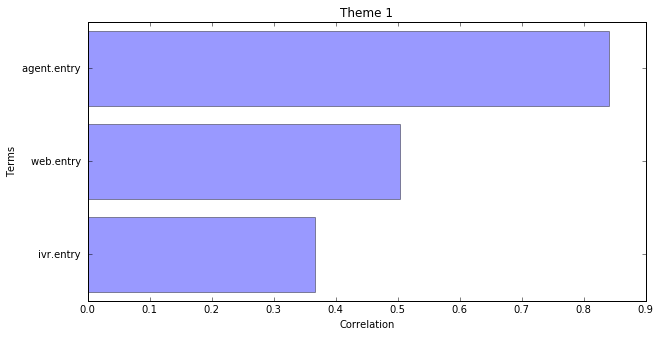

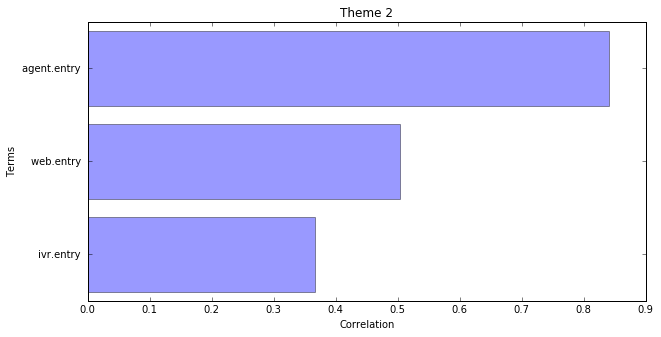

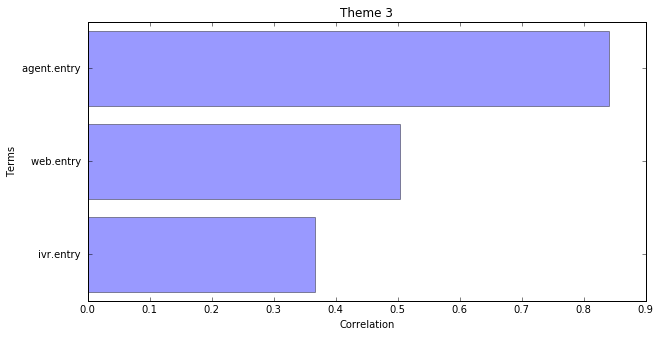

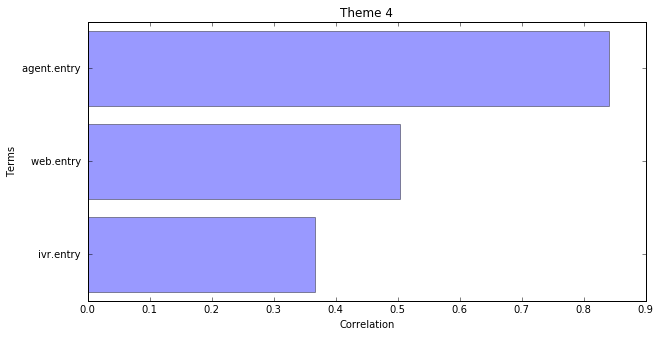

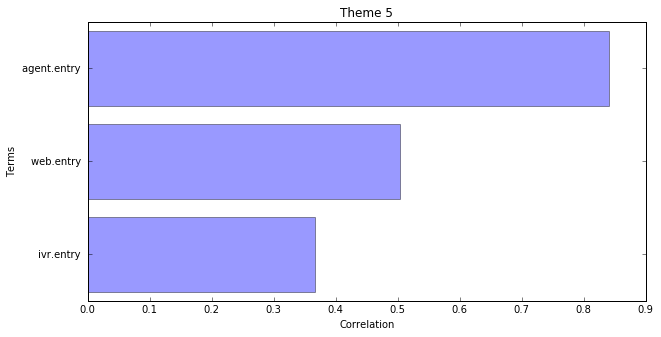

In [17]:
for i in range(5):
    graph_term_import(word_df.iloc[i, :], i+1)